<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/main/MMI513_PA6_BeeDroids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMI513 Programming Assignment 6
# Group Movement: Flocking Algorithm
- İsmail Hakkı Armutcu
- 2374395

Preamble


In [454]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML ## for saving the animation video

# Utility Functions

In [455]:
DAVOIDANCE = 3 ## Avoidance Distance
DATTRACTANCE = 0.7 ## Attraction Distance
## If a beeDroid's distance is DATTRACTANCE to Attractor, it visits the Attractor
ATTRACTANCETIME = 2 ## The time a beeDroid visits the Attractor
TOTALATTRACTIONTIME = 30 ## All the Attractors becomes passive after this time

def unitvector(vec):
    nrm =  np.linalg.norm(vec)
    if nrm == 0:
        vec = np.random.rand(2)
    return vec / np.linalg.norm(vec)

def initialpositions(numboids, xlims, ylims, obstacleset):
    count = 0
    post = np.empty((1,2))
    while count < numboids:
        x = np.random.rand(1) * (xlims[1] - xlims[0]) + xlims[0]
        y = np.random.rand(1) * (ylims[1] - ylims[0]) + ylims[0]
        pos = np.array([x, y]).reshape((1,2))
        inflag = False
        for obstacle in obstacleset:
            posobs = obstacle.getposition()
            dist = np.linalg.norm(pos - posobs)
            if dist < obstacle.getradius():
                inflag = True
        if not inflag:
            post = np.concatenate([post, pos], axis=0)
            count += 1
    return post

def initialheadings(numboids):
    thetas = np.random.rand(numboids) * 2 * np.pi
    heads = np.zeros((numboids, 2))
    for ind in range(numboids):
        heads[ind, :] = np.array([np.cos(thetas[ind]), np.sin(thetas[ind])])
    return heads

def initialspeeds(numboids, minspeed, maxspeed):
    speeds = np.random.rand(numboids) * (maxspeed - minspeed) + minspeed
    return speeds

def cart2polar(xvec):
    th = np.arctan2(xvec[1], xvec[0])
    return th

def setdeepcopy(A):
    B = set()
    for item in A:
        B.add(item.copy())
    return B

def setcombine(A, B):
    C = setdeepcopy(A)
    if B==None:
        return A
    for item in B:
        C.update({item.copy()})
    return C

# Class for BeeDroids
## Added Parameters:
- ID
- InAttractor

In [456]:
class Boid:
    def __init__(self, position=np.array([0., 0.]), heading=np.array([1., 1.]), leadflag=False, perceptionradius=2., speed=1, id=0):
        super().__init__()
        self._position = position
        self._heading = unitvector(heading)
        self._leadflag = leadflag
        self._perceptionradius = perceptionradius
        self._velocity = self._heading * speed
        self._id = id
        self._inattractor = False
    def getid(self):
        return self._id
    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getheading(self):
        return self._heading

    def setheading(self, heading):
        self._heading = unitvector(heading)

    def getleader(self):
        return self._leadflag

    def setleader(self, leadflag):
        self._leadflag = leadflag

    def getradius(self):
        return self._perceptionradius

    def setradius(self, perceptionradius):
        self._perceptionradius = perceptionradius

    def getvelocity(self):
        return self._velocity

    def stop(self):
        self._velocity = unitvector(self._velocity) * 0

    def setvelocity(self, speed):
        self._velocity = unitvector(self._velocity) * speed
        self.setheading(unitvector(self._velocity))

    def addvelocity(self, velocity):
        self._velocity += velocity

    def copy(self):
        newboid = Boid()
        newboid.setheading(self._heading)
        newboid.setleader(self._leadflag)
        newboid.setposition(self._position)
        newboid.setvelocity(self._velocity)
        newboid._id = self._id
        newboid._inattractor = self._inattractor
        return newboid

    def vectortoother(self, otherboid):
        return self._position - otherboid.getposition()

    def distancetoother(self, other):
        v = self.vectortoother(other)
        return np.linalg.norm(v)

    def othervisible(self, otherboid):
        dst = self.distancetoother(otherboid)
        if dst < self._perceptionradius:
            return True
        return False

    def move(self):
        if not self._inattractor:
          self._position += self._velocity
        self._inattractor = False

# Class for Obstacles

In [457]:
class Obstacle:

    def __init__(self, position = np.array([9999., 9999.]), radiusbb = 0.3):
        super().__init__()
        self._position = position
        self._radiusbb = radiusbb

    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getradius(self):
        return self._radiusbb

    def setradius(self, radiusbb):
        self._radiusbb = radiusbb

    def copy(self):
        newobstacle = Obstacle()
        newobstacle.setposition(self._position)
        newobstacle.setradius(self._radiusbb)
        return newobstacle

# Class for Attractors
## Instance Variables:
- Time: to keep track of time limited attraction
- Active: If there is 3 beedroids visiting the attractor, it becomes passive.
- VisitedBoids: If a beedroid finishes visiting, it is added to this list and no more attracted.
- Visitors: To keep track of beedroids and their visiting times

In [458]:

class Attractor:

    def __init__(self, position = np.array([9999., 9999.]), radius = 0.3):
        super().__init__()
        self._time = 0
        self._position = position
        self._radius = radius
        self._active = True
        self._visitedBoids = [] # List to keep track of beedroids that visited the attractor
        self._visitors = {}  # Dictionary to track bees and their visiting durations

    def getactive(self):
      return self._active

    def setactive(self,active):
        self._active = active

    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getradius(self):
        return self._radius

    def setradius(self, radius):
        self._radius = radius

    def isactiveforboid(self, boid): #Is this attractor active for this beedroid
        if boid.getid() in self._visitors:
          return True
        elif self._active == False:
          return False
        elif len(self._visitors) >= 3:
          return False
        elif boid.getid() in self._visitedBoids:
          return False
        else:
          return True

    def visit(self, boid): ## The beedroid visits this attractor
        if boid.getid() not in self._visitors and boid.getid() not in self._visitedBoids:
          self._visitors[boid.getid()] = self._time  # Start timing the visit duration
          if boid.getid() in self._visitors:
            print("Boid:",boid.getid(),"visited attractor at:",self._position,"at time:",self._time)
        elif boid.getid() in self._visitors:
          print("Boid:",boid.getid(),"is in attractor at:",self._position,"at time:",self._time)
        elif boid.getid() in self._visitedBoids:
          print("Boid: ",boid.getid(),"has visited before")

    def update(self):# Manage visitor beedroids and time limited attraction
        self._time += 1
        visitors_copy = self._visitors.copy()
        for boid in visitors_copy:
            visitTime = self._time-self._visitors[boid]
            if visitTime >= ATTRACTANCETIME: # If a beedroid visits this attractor for longer than ATTRACTANCETIME, it is no more attracted
                del self._visitors[boid]
                self._visitedBoids.append(boid)
                print("Boid:",boid,"leaved attractor at",self._position,"at time:",self._time)
        if len(self._visitors) == 3:
          self._active = False
        else:
          self._active = True

        if self._time >= TOTALATTRACTIONTIME:
          self._active = False

        print("In attractor at:",self._position,"at time:",self._time,"visited boids:",self._visitedBoids,"visitors: ",self._visitors)

    def copy(self):
        newattractor = Attractor()
        newattractor.setposition(self._position)
        newattractor.setradius(self._radius)
        newattractor.setactive(self._active)
        newattractor._visitedBoids = self._visitedBoids
        newattractor._visitors = self._visitors
        newattractor._time = self._time
        return newattractor


#Functions to create sets


In [459]:
def flockset(numboids, xlims, ylims, minspeed, maxspeed, obstacleset, leaderind):
    F = set()
    post = initialpositions(numboids, xlims, ylims, obstacleset)
    heads = initialheadings(numboids)
    speeds = initialspeeds(numboids, minspeed, maxspeed)
    for ind in range(numboids):
        if ind == leaderind:
            F.add(Boid(position=post[ind+1,:], heading=heads[ind,:], leadflag=False, perceptionradius = 3, speed=speeds[ind], id = ind))
        else:
            F.add(Boid(position=post[ind+1,:], heading=heads[ind,:], leadflag=False,perceptionradius = 3, speed=speeds[ind], id = ind))
    return F

def obstacleset(positions, radii):
    Oset = set()
    for ind in range(len(positions)):
        obs = Obstacle(positions[ind], radii[ind])
        Oset.add(obs)
    return Oset

def attractorset(positions, radii):
    Aset = set()
    for ind in range(len(positions)):
        attr = Attractor(positions[ind], radii[ind])
        Aset.add(attr)
    return Aset


#Functions to plot objects

In [460]:
def plotflockset(F, fig,ax):
    xs, ys, ths = [], [], []
    for boid in F:
        position = boid.getposition()
        heading = boid.getheading()
        x, y = position[0], position[1]
        th = cart2polar(heading)
        ths.append(np.rad2deg(th))
        xs.append(x)
        ys.append(y)
        ax.scatter(x, y, marker=(3, 0, np.rad2deg(th)))
    fig.tight_layout()
    return fig,ax

def plotobstacleset(A,fig,ax):
    for obs in A:
        [x,y] = obs.getposition()
        ax.scatter(x,y,marker ='o',color = 'r')
    fig.tight_layout()
    return fig,ax

def plotattractorset(AttractorSet,fig,ax):## If the attractor has visitors its color will be blue, else it will be green
    for attr in AttractorSet:
      [x,y] = attr.getposition()
      if(len(attr._visitors)>=1):
        ax.scatter(x,y,s=90,marker ='*',color='b')
      else:
        ax.scatter(x,y,s=90,marker ='*',color='g')
    fig.tight_layout()
    return fig,ax


##Behavior Algorithms
- separation
- alignment
- cohesion
- avoidance
- attractance

In [461]:
def separation(M, boid, ds = 0.3):
    mindist = np.Inf
    cboid = Boid()
    for other in M:
        d = boid.distancetoother(other)
        if d < mindist:
            mindist = d
            cboid = other
    v = cboid.getposition() - boid.getposition()
    r = 1 - 2 * ds / (np.linalg.norm(v) + ds)
    return r * unitvector(v)

def alignment(M, boid):
    mindist = np.Inf
    cboid = Boid()
    for other in M:
        d = boid.distancetoother(other)
        if d < mindist:
            mindist = d
            cboid = other
    vel = cboid.getvelocity()
    return unitvector(vel)

def cohesion(M, boid):
    vec = np.array([0., 0.])
    for other in M:
        vec += other.getposition()
    vec /= len(M)
    vec -= boid.getposition()
    if np.isclose(np.linalg.norm(vec), 0):
        return np.array([0., 0.])
    return unitvector(vec)

def avoidance(A, boid):
    mindist = np.Inf
    closestobstacle = Obstacle()
    for obj in A:
        d = boid.distancetoother(obj)
        if d < mindist and d != 0:
            mindist = d
            closestobstacle = obj
    v = boid.getposition() - closestobstacle.getposition()
    if np.linalg.norm(v) <= DAVOIDANCE:
        return unitvector(v)
    return np.zeros(2)

def attractance(AttractorSet,boid): ## Attractance Behavior
    visibleAttractors = set()
    for attractor in AttractorSet: ## Find all visible and active attractors for the beedroid
        if boid.othervisible(attractor) and attractor.isactiveforboid(boid):
          visibleAttractors.add(attractor)


    mindist = np.Inf
    closestattractor = Attractor()
    for obj in visibleAttractors:   #Find the closest attractor that is visible and active for the beedroid
        d = boid.distancetoother(obj)
        if d < mindist:
            mindist = d
            closestattractor = obj

    if(mindist <= DATTRACTANCE): ## If the boid is within the radius, the boid visits the attractor
      boid._inattractor = True
      print("Attractance: boid",boid.getid(),"in attractor true attractor:",closestattractor.getposition())
      closestattractor.visit(boid)
      x,y = closestattractor.getposition()
      boid.setposition(np.array([x,y]))
      boid.stop()
    v = closestattractor.getposition() - boid.getposition()

    if np.linalg.norm(v) < DATTRACTANCE:
        return unitvector(v),boid
    return np.zeros(2),boid



# Flock Algorithm

In [462]:
def flock(B, ObstacleSet,AttractorSet, ws=0.2, wa=0.2, wc=0.4, wf=0.8, wattr=1.9, maxspeed=3):
    F = setdeepcopy(B)
    R = set()
    while len(F) > 0:
        f = F.pop()
        C = setcombine(F, R)
        V = set()
        for boid in C:
            if f.othervisible(boid):
                V.add(boid.copy())
        a = np.zeros(2)

        aseperation = np.zeros(2)
        aalignment = np.zeros(2)
        acohesion = np.zeros(2)
        aavoidance = np.zeros(2)
        aattractance = np.zeros(2)
        if len(V) == 0 or f.getleader():
            f.move()
            a = np.zeros(2)
        else:
            aseperation = ws * separation(V, f)
            aalignment = wa * alignment(V, f)
            acohesion = wc * cohesion(V, f)

        visibleObstacles = set()
        for object in ObstacleSet:
            if f.othervisible(object):
                visibleObstacles.add(object)
        aavoidance = wf * avoidance(visibleObstacles, f)

        aattractance,f = attractance(AttractorSet,f) ## Calculate acceleration for attraction, update the beedroid f
        aattractance = wattr * aattractance
        atotal = aseperation+ aalignment+ acohesion + aavoidance
        if np.linalg.norm(atotal- f.getvelocity()) >= maxspeed: ## If the calculated accelerations exceeds the bounds, normalize them
          percent = atotal/maxspeed
          aseperation /= percent
          aalignment /= percent
          acohesion /= percent
          aavoidance /= percent
          atotal = aseperation+ aalignment+ acohesion + aavoidance

        b = f.copy()
        b.addvelocity(atotal)
        if np.linalg.norm(b.getvelocity()) > maxspeed:
            b.setvelocity(maxspeed)
        b.move()
        R.update({b})
    for attractor in AttractorSet:
      attractor.update()
    return R

## Animation 1
In this scenario BeeDroids are within a cup shaped container surrounded with obstacles. The lid of the cup is open. After visiting and/or wandering around attractors, the attractors become passive and beedroids fly away. After this time, the attractors become passive and beedroids continue their flocking based on avoidance, cohesion, seperation and alignment.

In attractor at: [1.5 2. ] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [2. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [2. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1.5 2. ] at time: 1 visited boids: [] visitors:  {}
Attractance: boid 2 in attractor true attractor: [1.5 2. ]
Boid: 2 visited attractor at: [1.5 2. ] at time: 1
Attractance: boid 9 in attractor true attractor: [1.5 2. ]
Boid: 9 visited attractor at: [1.5 2. ] at time: 1
Attractance: boid 7 in attractor true attractor: [1.5 2. ]
Boid: 7 visited attractor at: [1.5 2. ] at time: 1
In attractor at: [2. 3.] at time: 2 visited boids: [] visitors:  {}
In attractor at: [1. 3.] at time: 2 visited boids: [] visitors:  {}
In attractor at: [1.5 2. ] at time: 2 visited boids: [] visitors:  {2: 1, 9: 1, 7: 1}
Attractance: boid 3 in attractor tru

In attractor at: [1.5 2. ] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [2. 3.] at time: 1 visited boids: [] visitors:  {}


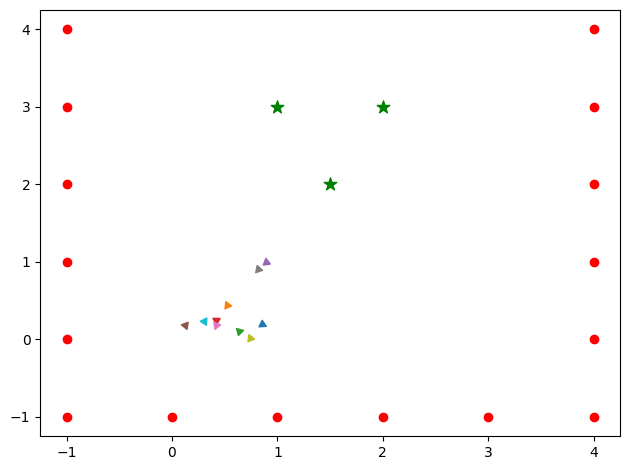

In [463]:
fig,ax = plt.subplots()
def update1(frame):
    global F,ax,fig,obsset,aset
    if frame == 0:
      positionsObstacle = [
                     np.array([4, 4]),np.array([4, 3]),np.array([4, 2]),np.array([4, 1]),np.array([4, 0]),np.array([4, -1]),
                     np.array([3, -1]),np.array([2, -1]),np.array([1, -1]),np.array([0, -1]),np.array([-1, -1]),
                     np.array([-1, 0]),np.array([-1, 1]),np.array([-1, 2]),np.array([-1, 3]),np.array([-1, 4])]
      radiiObstacle = [0.1]*16
      positionsAttractor = [np.array([1.0, 3.0]),np.array([2.0, 3.0]),np.array([1.5, 2.0])]
      radiiAttractor = [0.1]*3
      obsset = obstacleset(positionsObstacle, radiiObstacle)
      aset = attractorset(positionsAttractor, radiiAttractor)
      F = flockset(10, [0, 1], [0, 1], 0.1, 1., obsset, 5)

    ax.clear()
    fig,ax = plotobstacleset(obsset,fig,ax)
    fig,ax = plotflockset(F, fig,ax)
    fig,ax = plotattractorset(aset,fig,ax)
    fig.tight_layout()
    F = flock(F, obsset,aset)




ani = animation.FuncAnimation(fig, update1, frames=50, interval=250);
HTML(ani.to_html5_video())

# Animation 2
In this scenario, beedroids are in a closed container surrounded with obstacles. There are 3 attractors within the container. BeeDroids wander around the attractors for a set amount of time. After this time, the attractors become passive and beedroids continue their flocking based on avoidance, cohesion, seperation and alignment.

In attractor at: [1.5 2. ] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [2. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [2. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1.5 2. ] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1. 3.] at time: 1 visited boids: [] visitors:  {}
Attractance: boid 5 in attractor true attractor: [1.5 2. ]
Boid: 5 visited attractor at: [1.5 2. ] at time: 1
Attractance: boid 1 in attractor true attractor: [1.5 2. ]
Boid: 1 visited attractor at: [1.5 2. ] at time: 1
In attractor at: [2. 3.] at time: 2 visited boids: [] visitors:  {}
In attractor at: [1.5 2. ] at time: 2 visited boids: [] visitors:  {5: 1, 1: 1}
In attractor at: [1. 3.] at time: 2 visited boids: [] visitors:  {}
Attractance: boid 4 in attractor true attractor: [1.5 2. ]
Boid: 4 visited attractor at: [1.5 2. ] at time: 2
Attractance: boid 5 in attractor true attr

In attractor at: [1.5 2. ] at time: 1 visited boids: [] visitors:  {}
In attractor at: [2. 3.] at time: 1 visited boids: [] visitors:  {}
In attractor at: [1. 3.] at time: 1 visited boids: [] visitors:  {}


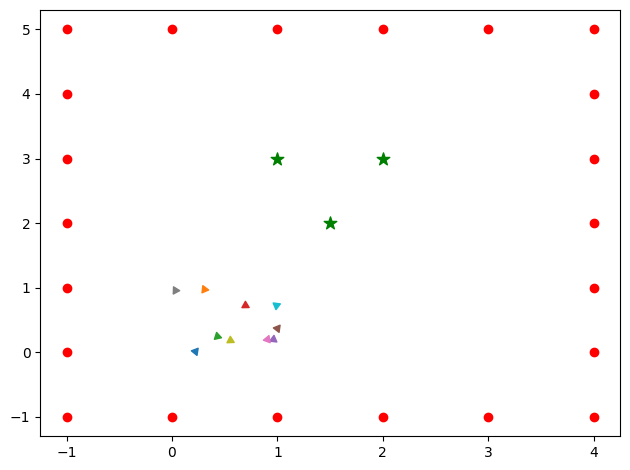

In [464]:
fig,ax = plt.subplots()
def update2(frame):
    global F,ax,fig,obsset,aset
    if frame == 0:
      positionsObstacle = [np.array([-1, 5]),np.array([0, 5]),np.array([1, 5]),np.array([2, 5]),np.array([3, 5]),np.array([4, 5]),
                     np.array([4, 4]),np.array([4, 3]),np.array([4, 2]),np.array([4, 1]),np.array([4, 0]),np.array([4, -1]),
                     np.array([3, -1]),np.array([2, -1]),np.array([1, -1]),np.array([0, -1]),np.array([-1, -1]),
                     np.array([-1, 0]),np.array([-1, 1]),np.array([-1, 2]),np.array([-1, 3]),np.array([-1, 4])]
      radiiObstacle = [0.1]*22
      #positionsAttractor = [np.array([0.5, 1.]), np.array([1.5, 1.5]), np.array([2.2,2.2]), np.array([3.3,3.3]), np.array([1.5,3.])]
      #radiiAttractor = [0.1, 0.1, 0.1, 0.1, 0.1]
      #positionsObstacle = [np.array([-.5, 5.])]
      #radiiObstacle = [0.1]
      positionsAttractor = [np.array([1.0, 3.0]),np.array([2.0, 3.0]),np.array([1.5, 2.0])]
      radiiAttractor = [0.1]*3
      obsset = obstacleset(positionsObstacle, radiiObstacle)
      aset = attractorset(positionsAttractor, radiiAttractor)
      F = flockset(10, [0, 1], [0, 1], 0.1, 1., obsset, 5)

    ax.clear()
    fig,ax = plotobstacleset(obsset,fig,ax)
    fig,ax = plotflockset(F, fig,ax)
    fig,ax = plotattractorset(aset,fig,ax)
    F = flock(F, obsset,aset)




ani = animation.FuncAnimation(fig, update2, frames=75, interval=250);
HTML(ani.to_html5_video())